Interactively figure out MGRS tiles and track numbers

In [3]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [16]:
yaml_file = 'events/demak_flood_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'demak_flood_2024',
 'bounds': [110.00054153, -7.10254596, 111.30352226, -6.68671509],
 'event_date': '2024-03-15',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [150, 114],
 'mgrs_tiles': ['49MDN', '49MEN'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange',
 'links': ['https://data.humdata.org/dataset/satellite-detected-water-extents-between-4-11-july-2024-in-bangladesh',
  'https://data.humdata.org/dataset/satellite-detected-water-extent-over-jawa-tengah-province-indonesia-as-of-27-march-2024']}

# Read Geojson

In [17]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [9]:
# df_event.plot()

In [10]:
df_event.head()

name       date                              source_id  \
0  demak_flood_2024 2024-03-15  UNOSAT via humanitarian data exchange   

                                            geometry  
0  MULTIPOLYGON (((110.68327 -7.10235, 110.68346 ...

In [11]:
df_event.total_bounds

array([110.49054153,  -7.10254596, 111.30352226,  -6.68671509])

# Create Spatial AOI

In [12]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [13]:
bounds = aoi.bounds
bounds

(110.49054153400004,
 -7.102545963999944,
 111.30352226300005,
 -6.6867150909999395)

# Find MGRS tiles and Explore

In [18]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping.head()

tile_id    epsg                                            utm_wkt  \
1   49MDN   32749  MULTIPOLYGON(((399960 9300040,399960 9190240,5...   
2   49MEN   32749  MULTIPOLYGON(((499980 9300040,499980 9190240,6...   

                                            geometry  
1  MULTIPOLYGON (((110.09552 -6.33171, 110.09365 ...  
2  MULTIPOLYGON (((110.99982 -6.33250, 110.99982 ...

In [19]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [20]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['49MDN', '49MEN']

In [21]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

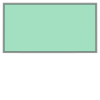

In [22]:
search_geo

# Explore Availability of RTC Data

In [23]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [24]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 10 simplified to 4 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


450

In [25]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 10 simplified to 4 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


240

In [29]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [30]:
df_rtc_resp_pre_e.pathNumber.unique()

array([ 54,  25, 127,  76,   3])

In [35]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([76, 127])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [34]:
df_rtc_resp_post_e.head()

0    LINESTRING (109.85274 -6.54980, 110.61811 -6.3...
1    LINESTRING (110.61725 -6.49516, 111.41839 -6.3...
2    LINESTRING (109.88903 -6.71662, 110.65472 -6.5...
3    LINESTRING (111.41889 -6.43021, 112.12448 -6.2...
4    LINESTRING (110.65393 -6.66204, 111.45537 -6.4...
dtype: geometry